# IDS.131 Preliminary Analysis
Miranda, Jinghong, Yue, Charlie, Meia

In [ ]:
from preprocess import *
from voronoi import create_voronoi

## Voronoi Diagram of Boston Bike sharing

In [ ]:
vor = create_voronoi()

## Load in and Preprocess Data

In [3]:
headers = get_headers(2018, 9)

# get the data we want to use
y2018 = {i+1: preprocess(2018, i+1) for i in range(9)}
y2017 = {i: preprocess(2017, i) for i in range(10,13)}

fullyear = np.vstack([month for month in {**y2017, **y2018}.values()])

# map of data column to what that column represents
index_map = {
    key: i for i, key in enumerate(headers)
}

# maps station ids to their respective latitudes and longitudes
station_coordinates = get_station_coordinates(fullyear)

print(headers)
print(index_map)

['tripduration', 'starttime', 'stoptime', 'startstationid', 'startstationname', 'startstationlatitude', 'startstationlongitude', 'endstationid', 'endstationname', 'endstationlatitude', 'endstationlongitude', 'bikeid', 'usertype', 'birthyear', 'gender"']
{'tripduration': 0, 'starttime': 1, 'stoptime': 2, 'startstationid': 3, 'startstationname': 4, 'startstationlatitude': 5, 'startstationlongitude': 6, 'endstationid': 7, 'endstationname': 8, 'endstationlatitude': 9, 'endstationlongitude': 10, 'bikeid': 11, 'usertype': 12, 'birthyear': 13, 'gender"': 14}


In [4]:
station_coordinates

{117: (42.36616223459919, -71.08688293667001),
 66: (42.34922469338298, -71.13275302578586),
 67: (42.3581, -71.093198),
 17: (42.364263440638524, -71.1182756971175),
 81: (42.352409, -71.062679),
 77: (42.386844, -71.09812),
 74: (42.373268, -71.118579),
 174: (42.3489528466951, -71.16031676530838),
 120: (42.356052, -71.069849),
 20: (42.35991176110118, -71.0514298081398),
 60: (42.36018499796463, -71.07086597688976),
 46: (42.3436658245146, -71.08582377433777),
 12: (42.33624444796878, -71.08798563480377),
 179: (42.355601213279265, -71.10394477844238),
 53: (42.35082680669095, -71.0898108780384),
 73: (42.373231, -71.120886),
 176: (42.38674802045056, -71.11901879310608),
 227: (42.34949599514002, -71.10057592391968),
 31: (42.34881026188269, -71.04167744055303),
 88: (42.374035, -71.101427),
 11: (42.338629, -71.1065),
 94: (42.375603, -71.064608),
 149: (42.363796, -71.129164),
 104: (42.380287, -71.125107),
 19: (42.347241, -71.105301),
 79: (42.37842, -71.105668),
 134: (42.350

In [5]:
morning = (4,10)  # inclusive, so from 4am to 11am.
evening = (16,19)  # inclusive, from 4pm to 8pm

## Station Usage Heat Maps

### For trips during month of sept 2018

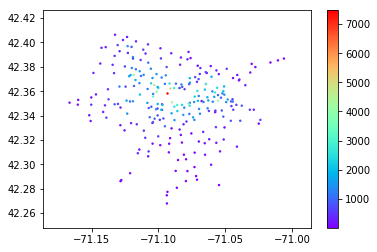

In [6]:
plot_station_use_heat_map(y2018[9], start=True)  # stations where the most trips originate for september 2018

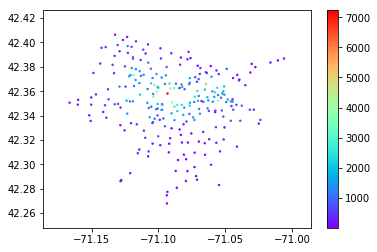

In [7]:
plot_station_use_heat_map(y2018[9], start=False)  # stations where the most trips end for september 2018

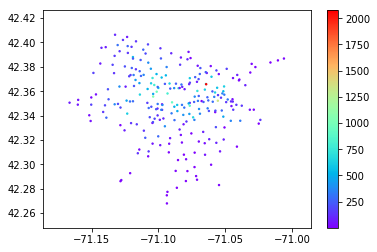

In [8]:
plot_station_use_heat_map(y2018[9], morning, True)  # morning commute origination (starting from 4am to 11am) for september 2018

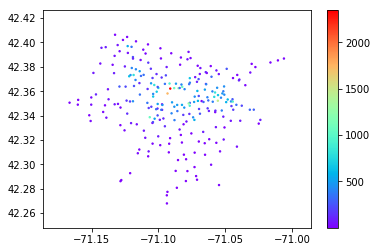

In [9]:
plot_station_use_heat_map(y2018[9], morning, False)  # morning commute destinations (starting from 4am to 11am) for september 2018

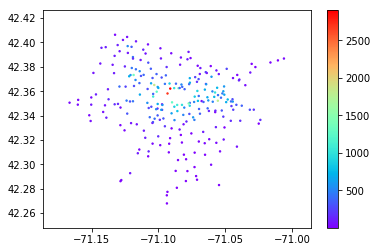

In [10]:
plot_station_use_heat_map(y2018[9], evening, True)  # evening commute origination (4pm to 8pm) for september 2018

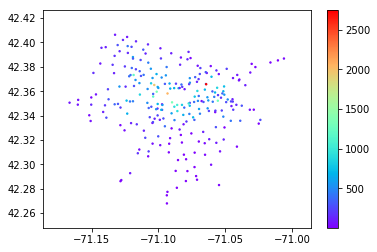

In [11]:
plot_station_use_heat_map(y2018[9], evening, False)  # evening commute destinations (4pm to 8pm) for september 2018

### Heat maps for rides from full past year: oct 2017 - sept 2018 (inclusive)

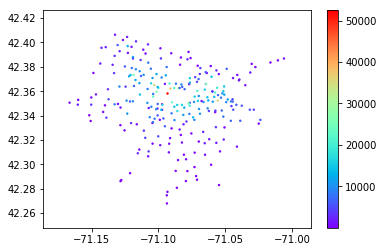

In [12]:
plot_station_use_heat_map(fullyear, start=True)  # stations where the most trips originate for october 2017 to september 2018

In [13]:
plot_station_use_heat_map(fullyear, start=False)  # stations where the most trips end for october 2017 to september 2018

Process ForkPoolWorker-62:
Process ForkPoolWorker-61:
Process ForkPoolWorker-60:
Process ForkPoolWorker-58:
Process ForkPoolWorker-64:
Process ForkPoolWorker-59:
Process ForkPoolWorker-63:
Process ForkPoolWorker-57:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocess

  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/dateutil/parser/_parser.py", line 1356, in parse
    return DEFAULTPARSER.parse(timestr, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/dateutil/parser/_parser.py", line 642, in parse
    default = datetime.datetime.now().replace(hour=0, minute=0,
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/dateutil/parser/_parser.py", line 642, in parse
    default = datetime.datetime.now().replace(hour=0, minute=0,
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/dateutil/parser/_parser.py", line 642, in parse
    default = datetime.datetime.now().replace(hour=0, minute=0,
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/dateutil/parser/_parser.py", line 642, in parse
    default = datetime.datetime.now().replace(hour=0, minute=0,
  File "/Library/Framew

Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-4f99754e365f>", line 1, in <module>
    plot_station_use_heat_map(fullyear, start=False)  # stations where the most trips end for october 2017 to september 2018
  File "/Users/meiaalsup/dev/mit/IDS.131/proj/preprocess.py", line 73, in plot_station_use_heat_map
    dataset = _narrow_dataset_by_time(dataset.copy(), interval)
  File "/Users/meiaalsup/dev/mit/IDS.131/proj/preprocess.py", line 60, in _narrow_dataset_by_time
    filtered = p.map(partial(_in_range, interval=interval), [i for i in dataset[:,index_map['starttime']]])
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/pool.py", line 288, in map
    return self._map_async(func, iterable, mapstar, chunksize).get()
  File "/Library/Framework

Traceback (most recent call last):


KeyboardInterrupt: 

  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/

  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/dateutil/parser/_parser.py", line 112, in get_token
    nextchar = self.instream.read(1)
KeyboardInterrupt


In [ ]:
plot_station_use_heat_map(fullyear, morning, True)  # morning commute origination (starting from 4am to 11am)

In [ ]:
plot_station_use_heat_map(fullyear, morning, False)  # morning commute destinations (starting from 4am to 11am)

In [ ]:
plot_station_use_heat_map(fullyear, evening, True)  # evening commute origination (4pm to 8pm)

In [ ]:
plot_station_use_heat_map(fullyear, evening, False)  # evening commute destinations (4pm to 8pm)

## Analytics of percentage of riders that are subscribers

In [ ]:
unique, count = np.unique(fullyear[:,index_map['usertype']], return_counts=True)
print(unique)
print(count)

In [ ]:
diff_start_end = fullyear[fullyear[:,index_map['startstationid']]  != fullyear[:,index_map['endstationid']]]

In [ ]:
unique, count = np.unique(diff_start_end[:,index_map['usertype']], return_counts=True)

In [ ]:
print(unique, count)